# Rt Live Model

Based on [Rt.live](https://Rt.live) model, original source code on [Github](https://github.com/rtcovidlive/covid-model).

Adapted for South Africa - Schalk van Heerden, "Reviewer" - 18 July 2020 - **Review required!**

In [1]:
%load_ext autoreload
%autoreload 2

from pip._internal import main
try:
    import pymc3 as pm
except:
    from pip._internal import main
    main(['install', 'pymc3'])
    import pymc3 as pm
        
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

## Setup
TODO: Complete GitHub automation. Progress: can install all libaries with conda, but issue running this complex notebook remotely in a GitHub Action. Move to a flat python file next.

Change paramter to **False** when running on your own local machine, but do not commit this change! Leave as **True** for Github Action `rtlive_model_action.yaml` to run remotely.

In [2]:
us_run = False

In [3]:
remote_run = False

## Troubleshooting

1. Ensure that all modules are installed with `conda` from `requirements.txt`
1. How to solve Theano library warnings on some OS platforms: [SO](https://stackoverflow.com/questions/53423610/how-to-update-scan-cython-code-in-theano)

# Baseline model with US data

While testing, run US model first to baseline the latest model files. Remote run is not required. For the latest stable model, checkout commit from 2 July 2020.

## Fetch data and select the state's data

In [4]:
if us_run:
    df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [5]:
if us_run:
    region = "OR"
    model_data = df.loc[region]
    model_data.tail()

## Create the model instance and sample

In [6]:
if us_run:
    gm = GenerativeModel(region, model_data)
    gm.sample()

## Summarize Model Output

In [7]:
result = pd.DataFrame()
if us_run:
    result = summarize_inference_data(gm.inference_data)
result.tail(10)

""


## Plot Model Output

In [8]:
def plot_results():
    fig, ax = plt.subplots(figsize=(10,5))
    result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
    result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
    result.infections.plot(c="b", label="Infections")
    gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
    fig.set_facecolor('w')
    ax.legend();
 
if us_run:
    plot_results()

In [9]:
def plot_rt():
    fig, ax = plt.subplots(figsize=(10,5))

    ax.set_title(f"{region} $R_t$")
    samples = gm.trace['r_t']
    x=result.index
    cmap = plt.get_cmap("Reds")
    percs = np.linspace(51, 99, 40)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    samples = samples.T

    result["median"].plot(c="k", ls='-')

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(samples, p, axis=1)
        lower = np.percentile(samples, 100-p, axis=1)
        color_val = colors[i]
        ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

    ax.axhline(1.0, c="k", lw=1, linestyle="--")
    fig.set_facecolor('w')
 
if us_run:
    plot_rt()

# South African Results

## Download data

In [10]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_cases.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-07-13,20200713,52058.0,5632.0,103713.0,27387.0,3316.0,4299.0,1522.0,10525.0,79344.0,0.0,287796,https://twitter.com/DrZweliMkhize/status/12827...
2020-07-14,20200714,53959.0,5973.0,107070.0,30587.0,3458.0,4576.0,1579.0,10784.0,80199.0,107.0,298292,https://sacoronavirus.co.za/2020/07/14/update-...
2020-07-15,20200715,55584.0,6561.0,112714.0,32939.0,3645.0,5051.0,1667.0,11225.0,81556.0,107.0,311049,https://twitter.com/nicd_sa/status/12834853912...
2020-07-16,20200716,57186.0,7312.0,117895.0,35604.0,3883.0,5572.0,1831.0,11891.0,82986.0,61.0,324221,https://twitter.com/nicd_sa/status/12838318402...
2020-07-17,20200717,58860.0,8290.0,123408.0,37722.0,4160.0,6073.0,2044.0,12722.0,84254.0,61.0,337594,https://twitter.com/nicd_sa/status/12842052987...


In [11]:
#url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_testing.csv'
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests.tail()

,YYYYMMDD,cumulative_tests,recovered,hospitalisation,critical_icu,ventilation,deaths,contacts_identified,contacts_traced,scanned_travellers,passengers_elevated_temperature,covid_suspected_criteria,source
date,,,,,,,,,,,,,
2020-07-13,20200713,2194624.0,138241,NaN,NaN,NaN,4172,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/13/update-...
2020-07-14,20200714,2232738.0,146279,NaN,NaN,NaN,4346,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/14/update-...
2020-07-15,20200715,2278127.0,160693,NaN,NaN,NaN,4453,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/15/update-...
2020-07-16,20200716,2324923.0,165591,NaN,NaN,NaN,4669,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/16/update-...
2020-07-17,20200717,2373053.0,178183,NaN,NaN,NaN,4804,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/17/update-...


## Cleanup data

In [12]:
cases = pd.Series(states_cases['total'], index=states_cases.index, name='cases')
cases

date
2020-03-05         1
2020-03-07         2
2020-03-08         3
2020-03-09         7
2020-03-11        13
               ...  
2020-07-13    287796
2020-07-14    298292
2020-07-15    311049
2020-07-16    324221
2020-07-17    337594
Name: cases, Length: 133, dtype: int64

In [13]:
casezero = states_cases.index[0]
caselast = states_cases.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-07-17 00:00:00'))

In [14]:
idx = pd.date_range(casezero, caselast)

In [15]:
tests_all = pd.Series(states_tests['cumulative_tests'], index=states_tests.index, name='tests')
tests_all

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-07-13    2194624.0
2020-07-14    2232738.0
2020-07-15    2278127.0
2020-07-16    2324923.0
2020-07-17    2373053.0
Name: tests, Length: 140, dtype: float64

In [16]:
tests = tests_all.loc[casezero:caselast]
tests

date
2020-03-06        200.0
2020-03-07        241.0
2020-03-11        645.0
2020-03-12        848.0
2020-03-13        924.0
                ...    
2020-07-13    2194624.0
2020-07-14    2232738.0
2020-07-15    2278127.0
2020-07-16    2324923.0
2020-07-17    2373053.0
Name: tests, Length: 131, dtype: float64

In [17]:
combined_model = pd.concat([cases, tests], axis=1)
combined_model

,cases,tests
date,,
2020-03-05,1.0,NaN
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-07-13,287796.0,2194624.0
2020-07-14,298292.0,2232738.0
2020-07-15,311049.0,2278127.0


In [18]:
# Assume previous day testing result for missing data point
combined_model.loc[casezero,'tests'] = 163

In [19]:
# Reindex complete date range
filled_model = combined_model.reindex(idx, method='ffill')
filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-07-13,287796.0,2194624.0
2020-07-14,298292.0,2232738.0
2020-07-15,311049.0,2278127.0
2020-07-16,324221.0,2324923.0


In [20]:
# Do a final clean up, assume previous day results for missing data points
final_filled_model = filled_model.ffill(axis=0)
final_filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,1.0,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,241.0
2020-03-09,7.0,241.0
...,...,...
2020-07-13,287796.0,2194624.0
2020-07-14,298292.0,2232738.0
2020-07-15,311049.0,2278127.0
2020-07-16,324221.0,2324923.0


In [21]:
# Add delta columns for models
final_filled_model['positive'] = final_filled_model['cases'].diff()
final_filled_model['total'] = final_filled_model['tests'].diff()
final_filled_model

,cases,tests,positive,total
2020-03-05,1.0,163.0,NaN,NaN
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
...,...,...,...,...
2020-07-13,287796.0,2194624.0,11554.0,40233.0
2020-07-14,298292.0,2232738.0,10496.0,38114.0
2020-07-15,311049.0,2278127.0,12757.0,45389.0
2020-07-16,324221.0,2324923.0,13172.0,46796.0


In [22]:
df_model = final_filled_model.iloc[1:]
df_model

,cases,tests,positive,total
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
2020-03-10,7.0,241.0,0.0,0.0
...,...,...,...,...
2020-07-13,287796.0,2194624.0,11554.0,40233.0
2020-07-14,298292.0,2232738.0,10496.0,38114.0
2020-07-15,311049.0,2278127.0,12757.0,45389.0
2020-07-16,324221.0,2324923.0,13172.0,46796.0


## Calculate Rt

In [23]:
region = 'Total RSA'

In [24]:
gm = GenerativeModel(region, df_model)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [22:39<00:00,  2.65draws/s]


## Show results

In [25]:
result = summarize_inference_data(gm.inference_data)

100%|██████████| 800/800 [00:05<00:00, 147.59it/s]


In [26]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-07-08,1.120618,1.116118,0.940710,1.293420,7376.076250,7835.976332,7677.905600,8810.0,36867.0
2020-07-09,1.121955,1.117104,0.936052,1.299875,7558.113348,8024.582087,7821.603749,13674.0,56170.0
2020-07-10,1.122120,1.110425,0.931131,1.310389,7750.542087,8215.244386,7001.671245,12348.0,56663.0
2020-07-11,1.122293,1.111633,0.901168,1.284789,7955.938178,8408.528749,8447.009078,13497.0,51338.0
2020-07-12,1.122789,1.117317,0.898425,1.292631,8173.033463,8605.152869,8455.034328,12058.0,45821.0
2020-07-13,1.122728,1.120758,0.915134,1.321686,8401.351920,8806.007521,9226.874311,11554.0,40233.0
2020-07-14,1.123448,1.107048,0.896155,1.309188,8642.344249,9012.037840,8847.976308,10496.0,38114.0
2020-07-15,1.124398,1.110379,0.897488,1.322511,8897.397628,9224.068023,9030.308757,12757.0,45389.0
2020-07-16,1.128099,1.112365,0.888220,1.329150,9167.641937,9443.082857,9043.731257,13172.0,46796.0


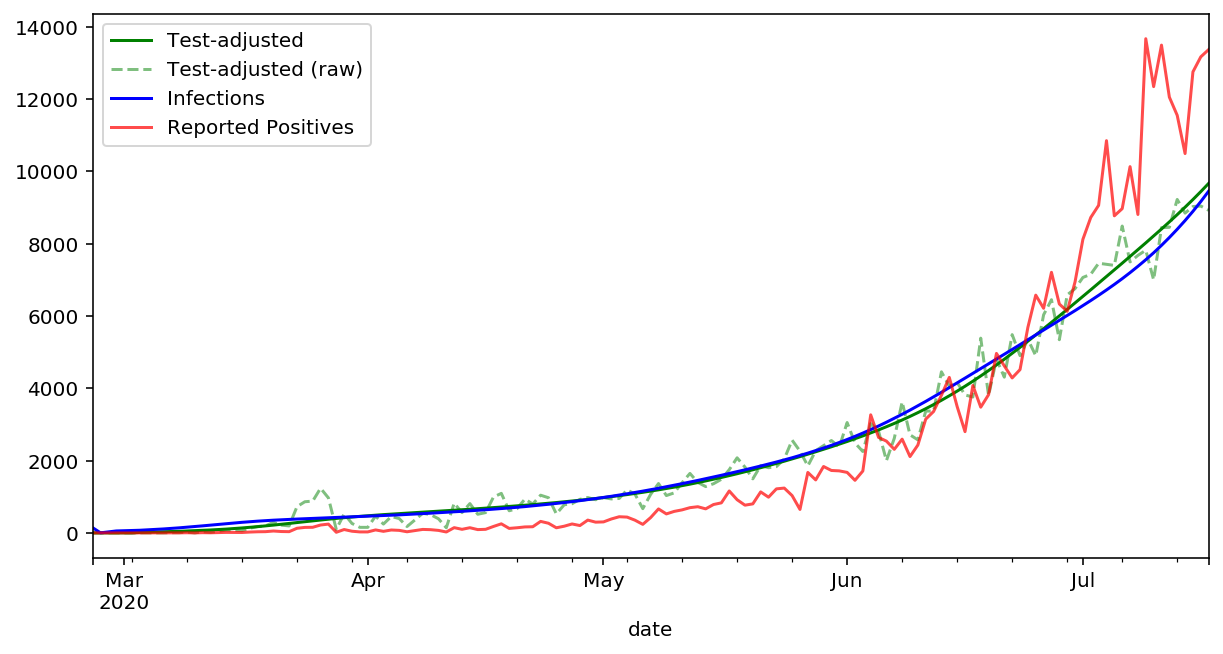

In [27]:
plot_results()

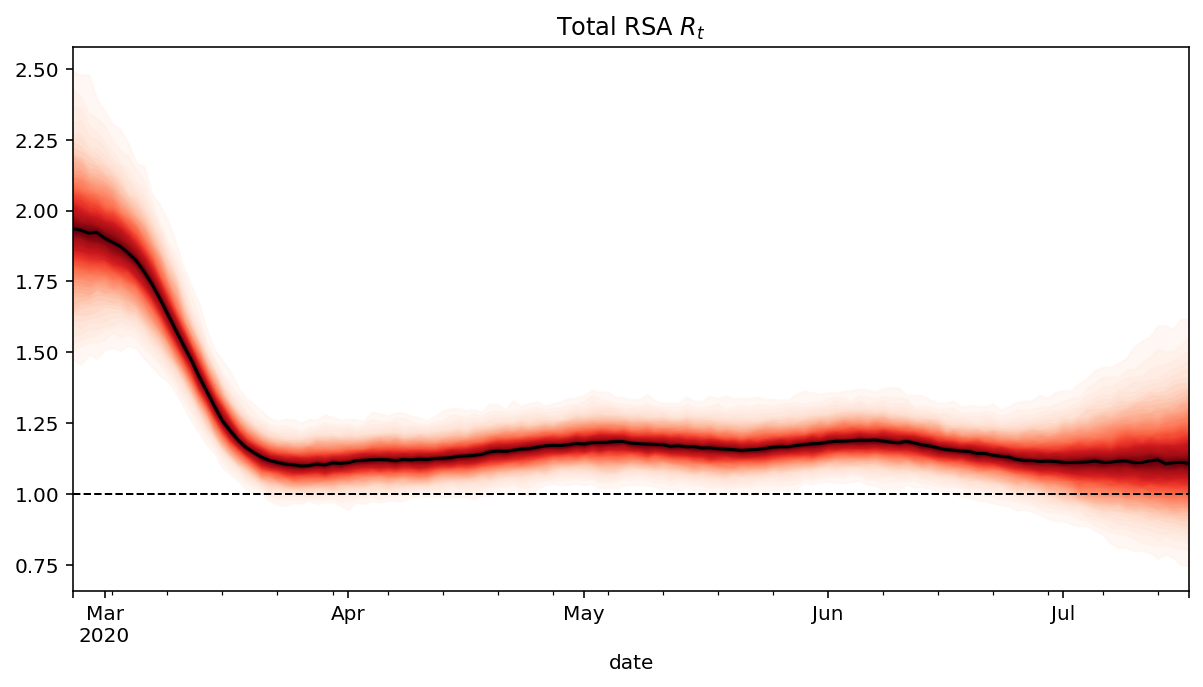

In [28]:
plot_rt()

In [29]:
export_results = result[['median','upper_80','lower_80']]
export_results = export_results.rename(columns={'median':'Median','upper_80':'High_80','lower_80':'Low_80'})
export_results.tail()

,Median,High_80,Low_80
date,,,
2020-07-13,1.120758,1.321686,0.915134
2020-07-14,1.107048,1.309188,0.896155
2020-07-15,1.110379,1.322511,0.897488
2020-07-16,1.112365,1.329150,0.888220
2020-07-17,1.107686,1.365523,0.908454


## Export results

In [30]:
if remote_run:
    # Used by GitHub Action, TODO complete the action!
    # The path needs to be linked directly, TODO find out why relative path does not work
    # Action instance path /home/runner/work/covid19za/covid19za
    export_results.to_csv('data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')

else:
    export_results.to_csv('../../data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')